In [16]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
from pulp import LpMaximize, LpMinimize, LpProblem, LpStatus, lpSum, LpVariable


In [4]:
### Simple linear programming sample
# Create the model
model = LpProblem(name="small-problem", sense=LpMaximize)

# Initialize the decision variables
x = LpVariable(name="x", lowBound=0)
y = LpVariable(name="y", lowBound=0)

# Add the constraints to the model
model += (2 * x + y <= 20, "red_constraint")
model += (4 * x - 5 * y >= -10, "blue_constraint")
model += (-x + 2 * y >= -2, "yellow_constraint")
model += (-x + 5 * y == 15, "green_constraint")

# Add the objective function to the model
obj_func = x + 2 * y
model += obj_func

# Solve the problem
status = model.solve()

print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

for var in model.variables():
    print(f"{var.name}: {var.value()}")

for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

status: 1, Optimal
objective: 16.8181817
x: 7.7272727
y: 4.5454545
red_constraint: -9.99999993922529e-08
blue_constraint: 18.181818300000003
yellow_constraint: 3.3636362999999996
green_constraint: -2.0000000233721948e-07


In [18]:
def toy_model(t, y, ydot, params):
    kc=12.; km=10.; lam=1.93E-4; Vin=1.; e0=0.0467
    T = 1; E = 2; X = 2
    A, W = params
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - y[2]*nonlinearity(y[0], kc, km)
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    for e in range(E):
        ydot[e+X] = -lam*y[e+X] + np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]]))
    ydot[E+X] = (Vin - y[X+1]*nonlinearity(y[X-1], kc, km))**2 #J1
    ydot[E+X+1] = np.sum([np.sum(A[e]*np.array([activation(y[T], W[e][2], W[e][1], W[e][0]), repression(y[T], W[e][2], W[e][1], W[e][0]), W[e][2]])) for e in range(E)]) #J2

def name_converter(A):
    if A == 1:
        return ((0, 1, 0), (1, 0, 0))

    elif A == 2:
        return ((0, 0, 1), (0, 0, 1))

    elif A == 3:
        return ((0, 0, 1), (1, 0, 0))

    elif A == 4:
        return ((0, 1, 0), (0, 0, 1))
    else: return 'Invalid Circuit'

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
        """Computes scalarized loss including genetic constraint and product production"""
        loss = alpha1*j1 + alpha2*j2
        return j1, j2, loss

def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)
    
def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

In [25]:
### Toy model sample
# Create the model
model = LpProblem(name="toy-ode", sense=LpMinimize)

# Initialize the decision variables
A = LpVariable("architecture", lowBound=0, upBound=4, cat="Integer")
k1 = LpVariable("k1", lowBound=1E-7, upBound=1E-3, cat="Continuous")
k2 = LpVariable("k2", lowBound=1E-7, upBound=1E-3, cat="Continuous")
theta1 = LpVariable("theta1", lowBound=0.001, upBound=10, cat="Continuous")
theta2 = LpVariable("theta2", lowBound=0.001, upBound=10, cat="Continuous")

# Add the constraints to the model
def ode_fun(A, k1, k2, theta1, theta2):
    t = np.linspace(0, 5E4, 100) 
    y0 = np.array([2290., 0., 0., 0., 0., 0.])
    architecture = name_converter(A.value())
    param_values = [[2., k1.value(), theta1.value()], [2., k2.value(), theta2.value()]]
    extra_options = {'old_api': False, 'user_data': [architecture, param_values]}
    ode_solver = ode('cvode', toy_model, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2)
    return loss

model += (ode_fun(A, k1, k2, theta1, theta2), "ode_constraint")

# Add the objective function to the model
model += loss

# Solve the problem
status = model.solve()

TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

In [29]:
#Read in random sampling results
da100 = pd.read_csv('random_sampling/da100.csv')
da1k = pd.read_csv('random_sampling/da1000.csv')
da10k = pd.read_csv('random_sampling/da10000.csv')

dc100 = pd.read_csv('random_sampling/dc100.csv')
dc1k = pd.read_csv('random_sampling/dc1000.csv')
dc10k = pd.read_csv('random_sampling/dc10000.csv')

nc100 = pd.read_csv('random_sampling/nc100.csv')
nc1k = pd.read_csv('random_sampling/nc1000.csv')
nc10k = pd.read_csv('random_sampling/nc10000.csv')

ur100 = pd.read_csv('random_sampling/ur100.csv')
ur1k = pd.read_csv('random_sampling/ur1000.csv')
ur10k = pd.read_csv('random_sampling/ur10000.csv')

In [30]:
#Read in grid search results
grid_search_timings = pd.DataFrame({'circuit':['da', 'dc','ur', 'nc'], 'time':[803, 921, 842, 885]})
gs_losses_dc = pd.read_csv('grid_search/dc_landscape_sundials.csv')
gs_losses_nc = pd.read_csv('grid_search/nc_landscape_sundials.csv')
gs_losses_da = pd.read_csv('grid_search/da_landscape_sundials.csv')
gs_losses_ur = pd.read_csv('grid_search/ur_landscape_sundials.csv')

In [31]:
#Combine all into best loss/computational time dataframe
combined = pd.DataFrame(columns=['Method', 'Circuit', 'Computational Time', 'Best Loss'])

def circuit_converter(circuit):
    if circuit == 'da': circuit_name = 'Downstream Activation'
    elif circuit == 'nc': circuit_name = 'No Control'
    elif circuit == 'dc': circuit_name = 'Dual Control'
    elif circuit == 'ur': circuit_name = 'Upstream Repression'
    return circuit_name

#Random sampling data processing
for df in [da100, da1k, da10k, dc100, dc1k, dc10k, nc100, nc1k, nc10k, ur100, ur1k, ur10k]:
    best_loss = df.loss.min()
    time = df.time[0]
    if str(df.num_samples[0]) == '100':
        method = '100 Random'
    elif str(df.num_samples[0]) == '1000':
        method = '1k Random'
    if str(df.num_samples[0]) == '10000':
        method = '10k Random'
    circuit = circuit_converter(df.circuit[0])
    row = pd.DataFrame({'Method': [method], 'Circuit': [circuit], 'Computational Time':[time], 'Best Loss':[best_loss]})
    combined = pd.concat([combined, row])

#Grid search data processing
for c in ['nc','dc','da','ur']:
    if c == 'nc': df = gs_losses_nc
    elif c == 'dc': df = gs_losses_dc
    elif c == 'da': df = gs_losses_da
    elif c == 'ur': df = gs_losses_ur
    best_loss = df.loss.min()
    time = grid_search_timings.loc[grid_search_timings.circuit == c].reset_index(drop=True).iloc[0].time
    method = 'Grid Search'
    circuit = circuit_converter(c)

    row = pd.DataFrame({'Method': [method], 'Circuit': [circuit], 'Computational Time':[time], 'Best Loss':[best_loss]})
    combined = pd.concat([combined, row])
    
combined.head()

,Method,Circuit,Computational Time,Best Loss
0,100 Random,Downstream Activation,0.663827,0.077568
0,1k Random,Downstream Activation,6.68774,0.066686
0,10k Random,Downstream Activation,68.817062,0.062072
0,100 Random,Dual Control,0.768979,0.066274
0,1k Random,Dual Control,7.912874,0.065841


Text(0, 0.5, 'Computational Time')

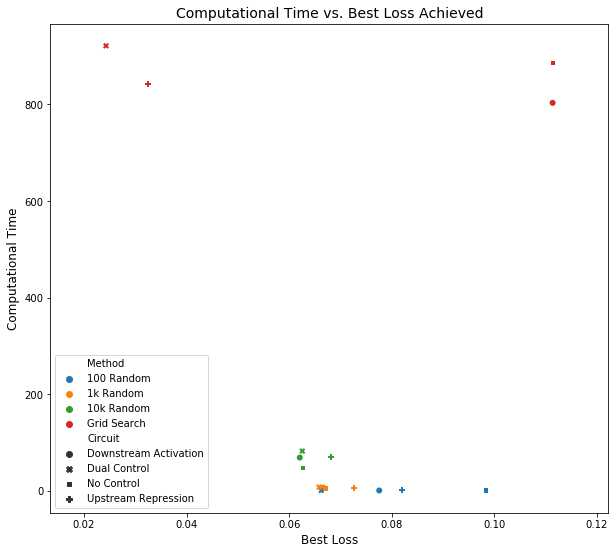

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(10, 9))
endpoint = 'Computational Time vs. Best Loss Achieved'
ax = axs
plot_data = combined #.loc[combined['Method'] != 'Grid Search']
sns.scatterplot(x="Best Loss", y="Computational Time",
                hue="Method", style="Circuit",
                sizes=(1, 8), linewidth=0,
                data=plot_data, ax=ax)

ax.legend()
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_xlabel('Best Loss', fontsize=12)
ax.set_ylabel('Computational Time, minutes', fontsize=12)